In [1]:
!pip install tqdm


In [2]:
import numpy as np
import random
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt


In [3]:
class GridWorld:
    def __init__(self, size=10, obstacle_ratio=0.2):
        self.size = size
        self.obstacle_ratio = obstacle_ratio
        self.reset()

    def reset(self):
        self.grid = np.full((self.size, self.size), '.')
        self.place_obstacles()
        self.start = self.place_random_cell('S')
        self.goal = self.place_random_cell('G')
        self.agent_pos = self.start
        return self.agent_pos

    def place_obstacles(self):
        total_cells = self.size * self.size
        num_obstacles = int(total_cells * self.obstacle_ratio)
        self.obstacles = set()
        while len(self.obstacles) < num_obstacles:
            x, y = random.randint(0, self.size - 1), random.randint(0, self.size - 1)
            self.obstacles.add((x, y))
        for x, y in self.obstacles:
            self.grid[x][y] = 'X'

    def place_random_cell(self, label):
        while True:
            x, y = random.randint(0, self.size - 1), random.randint(0, self.size - 1)
            if (x, y) not in self.obstacles and self.grid[x][y] == '.':
                self.grid[x][y] = label
                return (x, y)

    def step(self, action):
        x, y = self.agent_pos
        new_pos = {
            'UP': (x - 1, y),
            'DOWN': (x + 1, y),
            'LEFT': (x, y - 1),
            'RIGHT': (x, y + 1)
        }[action]

        if not (0 <= new_pos[0] < self.size and 0 <= new_pos[1] < self.size):
            return self.agent_pos, -10, False
        if new_pos in self.obstacles:
            return self.agent_pos, -10, False

        self.agent_pos = new_pos
        if self.agent_pos == self.goal:
            return self.agent_pos, 100, True
        return self.agent_pos, -1, False

    def render(self):
        display = np.copy(self.grid)
        x, y = self.agent_pos
        display[x][y] = 'A'
        for row in display:
            print(' '.join(row))
        print()


In [4]:
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.env = env
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

    def get_q(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        q_values = [self.get_q(state, a) for a in self.actions]
        max_q = max(q_values)
        return random.choice([a for a in self.actions if self.get_q(state, a) == max_q])

    def learn(self, state, action, reward, next_state):
        old_q = self.get_q(state, action)
        next_max = max([self.get_q(next_state, a) for a in self.actions])
        new_q = old_q + self.alpha * (reward + self.gamma * next_max - old_q)
        self.q_table[(state, action)] = new_q

    def train(self, episodes=500, max_steps=200):
        rewards = []
        for ep in range(episodes):
            state = self.env.reset()
            total_reward = 0
            for step in range(max_steps):
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.learn(state, action, reward, next_state)
                state = next_state
                total_reward += reward
                if done:
                    break
            rewards.append(total_reward)
        return rewards


In [5]:
class DQNAgent:
    def __init__(self, env, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995,
                 learning_rate=0.005, batch_size=32, memory_size=10000):
        self.env = env
        self.state_shape = (env.size, env.size)
        self.action_space = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        self.action_size = len(self.action_space)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.model = self.build_model(learning_rate)
        self.target_model = self.build_model(learning_rate)
        self.update_target_network()

    def build_model(self, lr):
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=self.state_shape),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(self.action_size)
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
        return model

    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice(range(self.action_size))
        q_values = self.model.predict(self.state_to_input(state), verbose=0)
        return np.argmax(q_values[0])

    def state_to_input(self, state):
        grid_input = np.zeros(self.state_shape)
        grid_input[state[0], state[1]] = 1
        return np.expand_dims(grid_input, axis=0)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states = np.zeros((self.batch_size,) + self.state_shape)
        next_states = np.zeros((self.batch_size,) + self.state_shape)
        actions, rewards, dones = [], [], []

        for i, (s, a, r, s2, d) in enumerate(minibatch):
            states[i][s[0], s[1]] = 1
            next_states[i][s2[0], s2[1]] = 1
            actions.append(a)
            rewards.append(r)
            dones.append(d)

        q_values = self.model.predict(states, verbose=0)
        q_next = self.target_model.predict(next_states, verbose=0)

        for i in range(self.batch_size):
            target = rewards[i]
            if not dones[i]:
                target += self.gamma * np.amax(q_next[i])
            q_values[i][actions[i]] = target

        self.model.fit(states, q_values, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, episodes=50, max_steps=100, update_target_freq=10):
        rewards = []
        for ep in range(episodes):
            state = self.env.reset()
            total_reward = 0
            for step in range(max_steps):
                action_idx = self.get_action(state)
                action = self.action_space[action_idx]
                next_state, reward, done = self.env.step(action)
                self.remember(state, action_idx, reward, next_state, done)
                state = next_state
                total_reward += reward
                if done:
                    break
                self.replay()
            if ep % update_target_freq == 0:
                self.update_target_network()
            rewards.append(total_reward)
        return rewards


In [6]:
from tqdm.notebook import tqdm

# Train Q-learning Agent
env1 = GridWorld(size=10)
q_agent = QLearningAgent(env1)
q_rewards = []
print("Training Q-learning Agent...")
for ep in tqdm(range(500), desc="Q-learning Progress"):
    state = env1.reset()
    total_reward = 0
    for step in range(200):
        action = q_agent.choose_action(state)
        next_state, reward, done = env1.step(action)
        q_agent.learn(state, action, reward, next_state)
        state = next_state
        total_reward += reward
        if done:
            break
    q_rewards.append(total_reward)

Training Q-learning Agent...


Q-learning Progress:   0%|          | 0/500 [00:00<?, ?it/s]

In [7]:
from tqdm.notebook import tqdm

# Reduce episodes for faster training
EPISODES = 50

# Reduce max steps per episode
MAX_STEPS = 100

env2 = GridWorld(size=10)
dqn_agent = DQNAgent(env2)

# smaller replay batch for faster computation
dqn_agent.batch_size = 32

dqn_rewards = []
print("Training DQN Agent...")
for ep in tqdm(range(EPISODES), desc="DQN Progress"):
    state = env2.reset()
    total_reward = 0
    for step in range(MAX_STEPS):
        action_idx = dqn_agent.get_action(state)
        action = dqn_agent.action_space[action_idx]
        next_state, reward, done = env2.step(action)
        dqn_agent.remember(state, action_idx, reward, next_state, done)
        state = next_state
        total_reward += reward

        # ✅ Replay less frequently
        if step % 4 == 0:  # 🔧 Instead of every step
            dqn_agent.replay()

        if done:
            break

    if ep % 5 == 0:  # 🔧 More frequent target updates can help with short training
        dqn_agent.update_target_network()

    dqn_rewards.append(total_reward)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training DQN Agent...


DQN Progress:   0%|          | 0/50 [00:00<?, ?it/s]

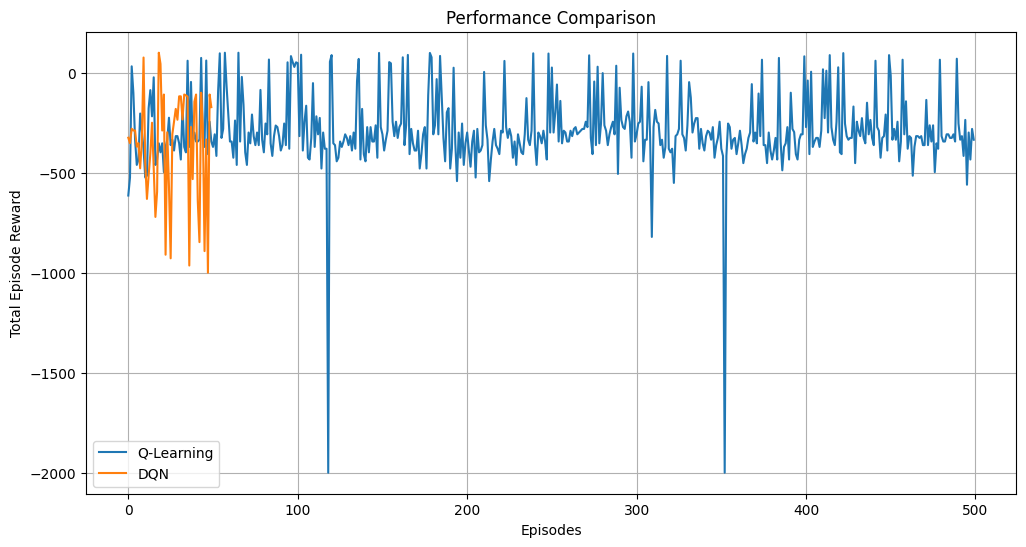

In [8]:
# Plotting Results
plt.figure(figsize=(12,6))
plt.plot(q_rewards, label='Q-Learning')
plt.plot(dqn_rewards, label='DQN')
plt.xlabel('Episodes')
plt.ylabel('Total Episode Reward')
plt.title('Performance Comparison')
plt.legend()
plt.grid()
plt.show()